# Round-Robin Strategy Analysis

This notebook analyzes the round-robin scheduling strategy - a baseline strategy that splits traffic evenly between all enabled flavours, ignoring carbon intensity and precision levels.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Data

In [2]:
# Load timeseries data
df = pd.read_csv('results/simple_20251120_190537/round-robin/timeseries.csv')

# Calculate percentages
df['total_requests'] = df['requests_precision_30'] + df['requests_precision_50'] + df['requests_precision_100']
df['p30_pct'] = (df['requests_precision_30'] / df['total_requests']) * 100
df['p50_pct'] = (df['requests_precision_50'] / df['total_requests']) * 100
df['p100_pct'] = (df['requests_precision_100'] / df['total_requests']) * 100

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Total samples: {len(df)}")
print(f"Duration: {df['elapsed_seconds'].max():.1f} seconds")
print(f"Total requests: {df['total_requests'].sum():.0f}")
df.head()

Total samples: 119
Duration: 602.7 seconds
Total requests: 286231


,timestamp,elapsed_seconds,delta_requests,mean_precision,credit_balance,credit_velocity,engine_avg_precision,carbon_now,carbon_next,requests_precision_30,...,replicas_consumer,replicas_target,ceiling_router,ceiling_consumer,ceiling_target,throttle_factor,total_requests,p30_pct,p50_pct,p100_pct
0,2025-11-20 19:07:05.416305+00:00,5.0,1985,0.5998,-0.264,-0.033,0.6,80.0,120.0,662,...,0,0,NaN,NaN,NaN,0.0,1985,33.350126,33.350126,33.299748
1,2025-11-20 19:07:10.544142+00:00,10.1,2386,0.5999,-0.297,-0.033,0.6,120.0,160.0,798,...,0,0,NaN,NaN,NaN,0.0,2386,33.445096,33.193630,33.361274
2,2025-11-20 19:07:15.614615+00:00,15.2,2475,0.6074,-0.363,-0.033,0.6,120.0,160.0,823,...,0,0,NaN,NaN,NaN,0.0,2475,33.252525,31.959596,34.787879
3,2025-11-20 19:07:20.676505+00:00,20.3,2326,0.6019,-0.396,-0.033,0.6,120.0,160.0,762,...,0,0,NaN,NaN,NaN,0.0,2326,32.760103,33.748925,33.490972
4,2025-11-20 19:07:25.757276+00:00,25.3,2509,0.6126,-0.429,-0.033,0.6,160.0,200.0,787,...,0,0,NaN,NaN,NaN,0.0,2509,31.367079,33.559187,35.073735


## 2. Carbon Intensity Distribution

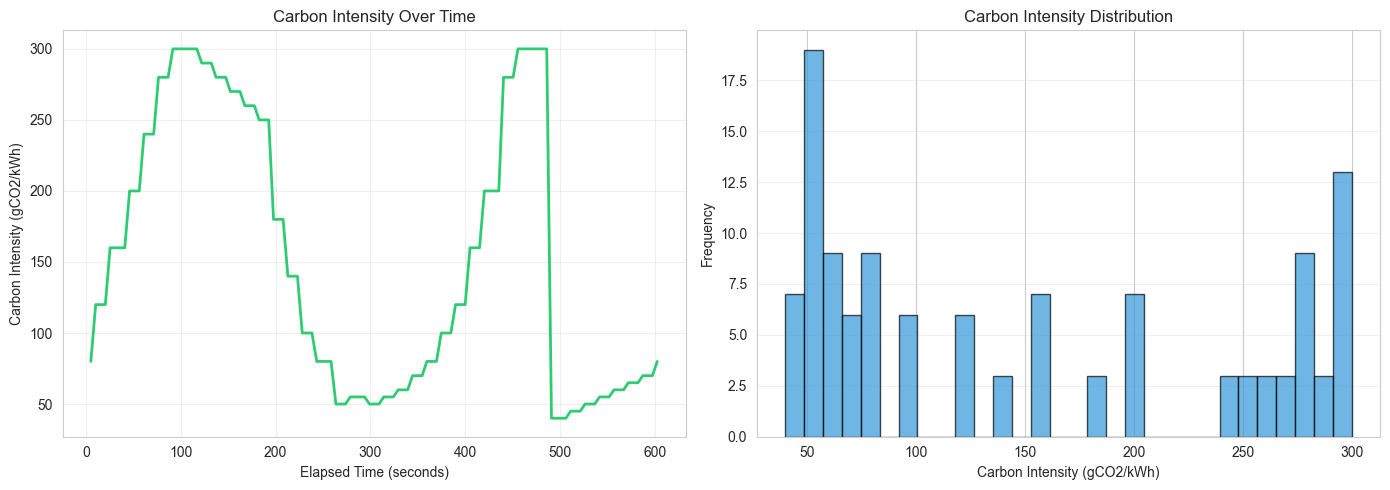

Carbon intensity range: 40 - 300 gCO2/kWh
Mean carbon intensity: 152.4 gCO2/kWh


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series of carbon intensity
axes[0].plot(df['elapsed_seconds'], df['carbon_now'], linewidth=2, color='#2ecc71')
axes[0].set_xlabel('Elapsed Time (seconds)')
axes[0].set_ylabel('Carbon Intensity (gCO2/kWh)')
axes[0].set_title('Carbon Intensity Over Time')
axes[0].grid(True, alpha=0.3)

# Distribution histogram
axes[1].hist(df['carbon_now'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Carbon Intensity (gCO2/kWh)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Carbon Intensity Distribution')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Carbon intensity range: {df['carbon_now'].min():.0f} - {df['carbon_now'].max():.0f} gCO2/kWh")
print(f"Mean carbon intensity: {df['carbon_now'].mean():.1f} gCO2/kWh")

## 3. Precision Distribution Over Time

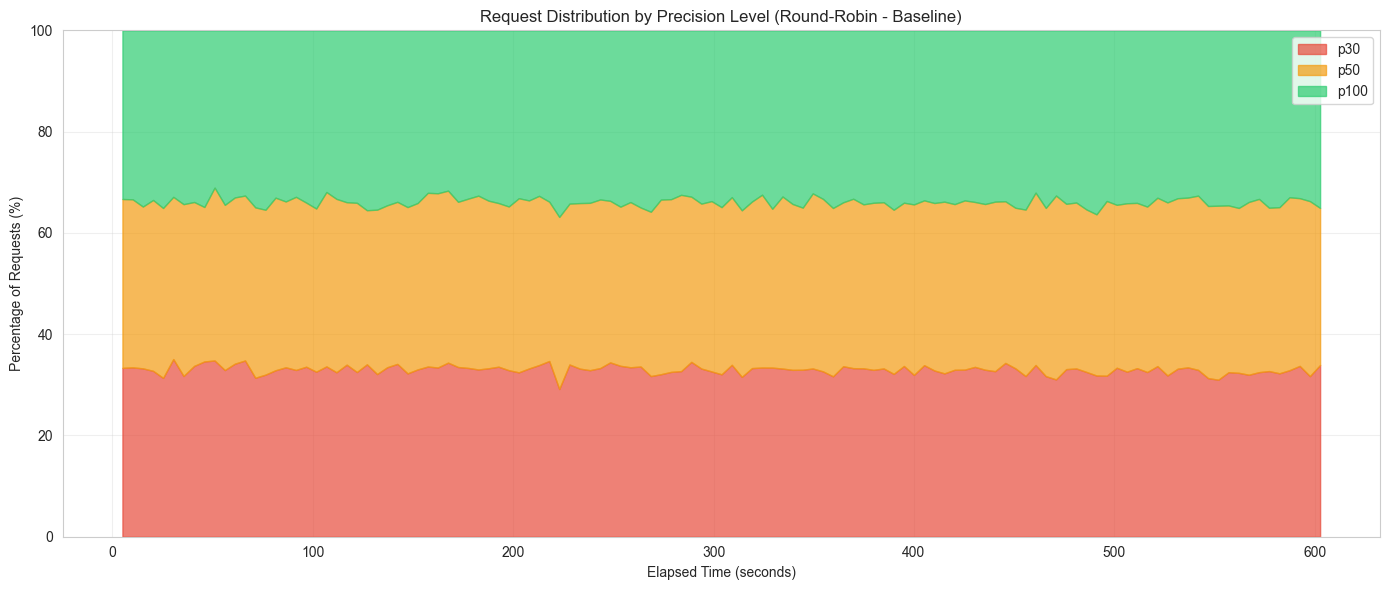

Overall precision distribution:
  p30: 33.0%
  p50: 33.1%
  p100: 33.9%

Expected even distribution: ~33.3% each


In [4]:
fig, ax = plt.subplots(figsize=(14, 6))

# Stacked area chart
ax.fill_between(df['elapsed_seconds'], 0, df['p30_pct'], label='p30', alpha=0.7, color='#e74c3c')
ax.fill_between(df['elapsed_seconds'], df['p30_pct'], df['p30_pct'] + df['p50_pct'], label='p50', alpha=0.7, color='#f39c12')
ax.fill_between(df['elapsed_seconds'], df['p30_pct'] + df['p50_pct'], 100, label='p100', alpha=0.7, color='#2ecc71')

ax.set_xlabel('Elapsed Time (seconds)')
ax.set_ylabel('Percentage of Requests (%)')
ax.set_title('Request Distribution by Precision Level (Round-Robin - Baseline)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("Overall precision distribution:")
print(f"  p30: {df['p30_pct'].mean():.1f}%")
print(f"  p50: {df['p50_pct'].mean():.1f}%")
print(f"  p100: {df['p100_pct'].mean():.1f}%")
print()
print("Expected even distribution: ~33.3% each")

## 4. Carbon-Aware Behavior Analysis

### Key Question: Does p100 usage vary between low and high carbon periods?

**Note**: Round-robin is a baseline strategy that should NOT show carbon-aware behavior - it always splits traffic evenly between all flavours.

In [5]:
# Define carbon level categories
very_low = df[df['carbon_now'] <= 60]
low = df[df['carbon_now'] <= 80]
mid = df[(df['carbon_now'] > 80) & (df['carbon_now'] < 240)]
high = df[df['carbon_now'] >= 240]
very_high = df[df['carbon_now'] >= 280]

print("=" * 80)
print("CARBON-AWARE BEHAVIOR ANALYSIS (BASELINE STRATEGY)")
print("=" * 80)
print()
print(f"VERY LOW (≤60 gCO2/kWh):  {len(very_low):3d} samples  |  p100: {very_low['p100_pct'].mean():5.1f}%  |  Weight: {very_low['commanded_weight_100'].mean():.1f}%")
print(f"LOW (≤80 gCO2/kWh):       {len(low):3d} samples  |  p100: {low['p100_pct'].mean():5.1f}%  |  Weight: {low['commanded_weight_100'].mean():.1f}%")
print(f"MID (80-240 gCO2/kWh):    {len(mid):3d} samples  |  p100: {mid['p100_pct'].mean():5.1f}%  |  Weight: {mid['commanded_weight_100'].mean():.1f}%")
print(f"HIGH (≥240 gCO2/kWh):     {len(high):3d} samples  |  p100: {high['p100_pct'].mean():5.1f}%  |  Weight: {high['commanded_weight_100'].mean():.1f}%")
print(f"VERY HIGH (≥280 gCO2/kWh): {len(very_high):3d} samples  |  p100: {very_high['p100_pct'].mean():5.1f}%  |  Weight: {very_high['commanded_weight_100'].mean():.1f}%")
print()
print(f"P100 SWING (Low - High): {low['p100_pct'].mean() - high['p100_pct'].mean():+.1f} percentage points")
print(f"P100 SWING (Very Low - Very High): {very_low['p100_pct'].mean() - very_high['p100_pct'].mean():+.1f} percentage points")
print()

swing = abs(low['p100_pct'].mean() - high['p100_pct'].mean())
if swing < 5:
    print("✅ EXPECTED: Minimal variation (<5 points) - Baseline strategy working correctly (not carbon-aware)")
elif swing < 10:
    print("⚠️ UNEXPECTED: Small variation (5-10 points) - Baseline showing some carbon sensitivity")
else:
    print("❌ PROBLEM: Significant variation (≥10 points) - Baseline strategy behaving unexpectedly!")

CARBON-AWARE BEHAVIOR ANALYSIS (BASELINE STRATEGY)

VERY LOW (≤60 gCO2/kWh):   32 samples  |  p100:  34.0%  |  Weight: 34.0%
LOW (≤80 gCO2/kWh):        50 samples  |  p100:  34.0%  |  Weight: 34.0%
MID (80-240 gCO2/kWh):     32 samples  |  p100:  34.0%  |  Weight: 34.0%
HIGH (≥240 gCO2/kWh):      37 samples  |  p100:  33.8%  |  Weight: 34.0%
VERY HIGH (≥280 gCO2/kWh):  25 samples  |  p100:  34.1%  |  Weight: 34.0%

P100 SWING (Low - High): +0.2 percentage points
P100 SWING (Very Low - Very High): -0.1 percentage points

✅ EXPECTED: Minimal variation (<5 points) - Baseline strategy working correctly (not carbon-aware)


### Visualization: p100 Usage vs Carbon Intensity

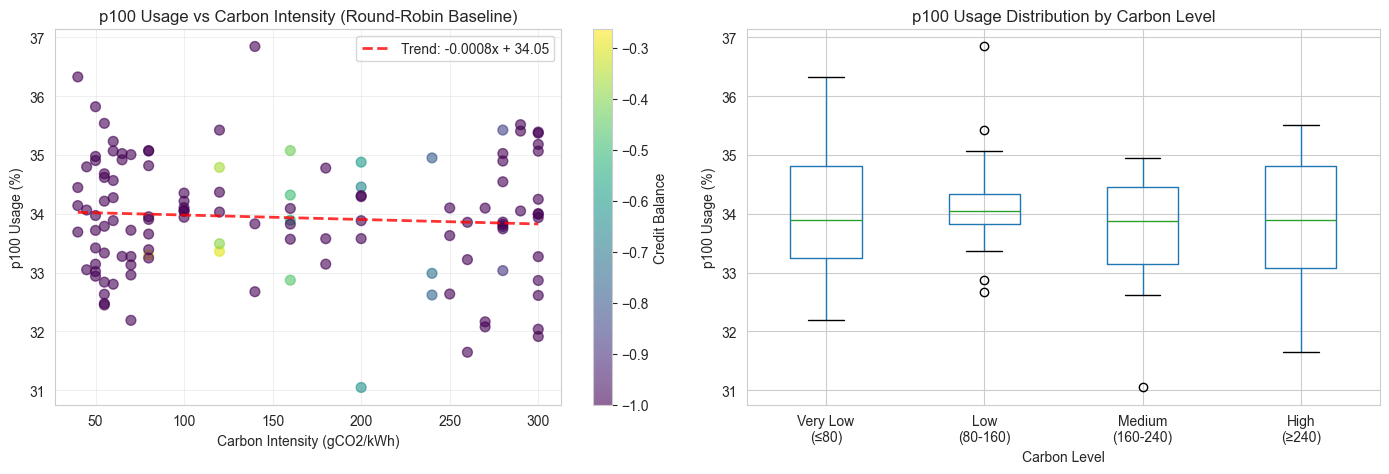

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
scatter = axes[0].scatter(df['carbon_now'], df['p100_pct'], c=df['credit_balance'], 
                          cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel('Carbon Intensity (gCO2/kWh)')
axes[0].set_ylabel('p100 Usage (%)')
axes[0].set_title('p100 Usage vs Carbon Intensity (Round-Robin Baseline)')
axes[0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Credit Balance')

# Trend line
z = np.polyfit(df['carbon_now'], df['p100_pct'], 1)
p = np.poly1d(z)
axes[0].plot(df['carbon_now'].sort_values(), p(df['carbon_now'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:.4f}x + {z[1]:.2f}')
axes[0].legend()

# Box plot by carbon category
carbon_categories = pd.cut(df['carbon_now'], bins=[0, 80, 160, 240, 400], 
                           labels=['Very Low\n(≤80)', 'Low\n(80-160)', 'Medium\n(160-240)', 'High\n(≥240)'])
df_plot = df.copy()
df_plot['carbon_category'] = carbon_categories
df_plot.boxplot(column='p100_pct', by='carbon_category', ax=axes[1])
axes[1].set_xlabel('Carbon Level')
axes[1].set_ylabel('p100 Usage (%)')
axes[1].set_title('p100 Usage Distribution by Carbon Level')
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

## 5. Credit Balance Dynamics

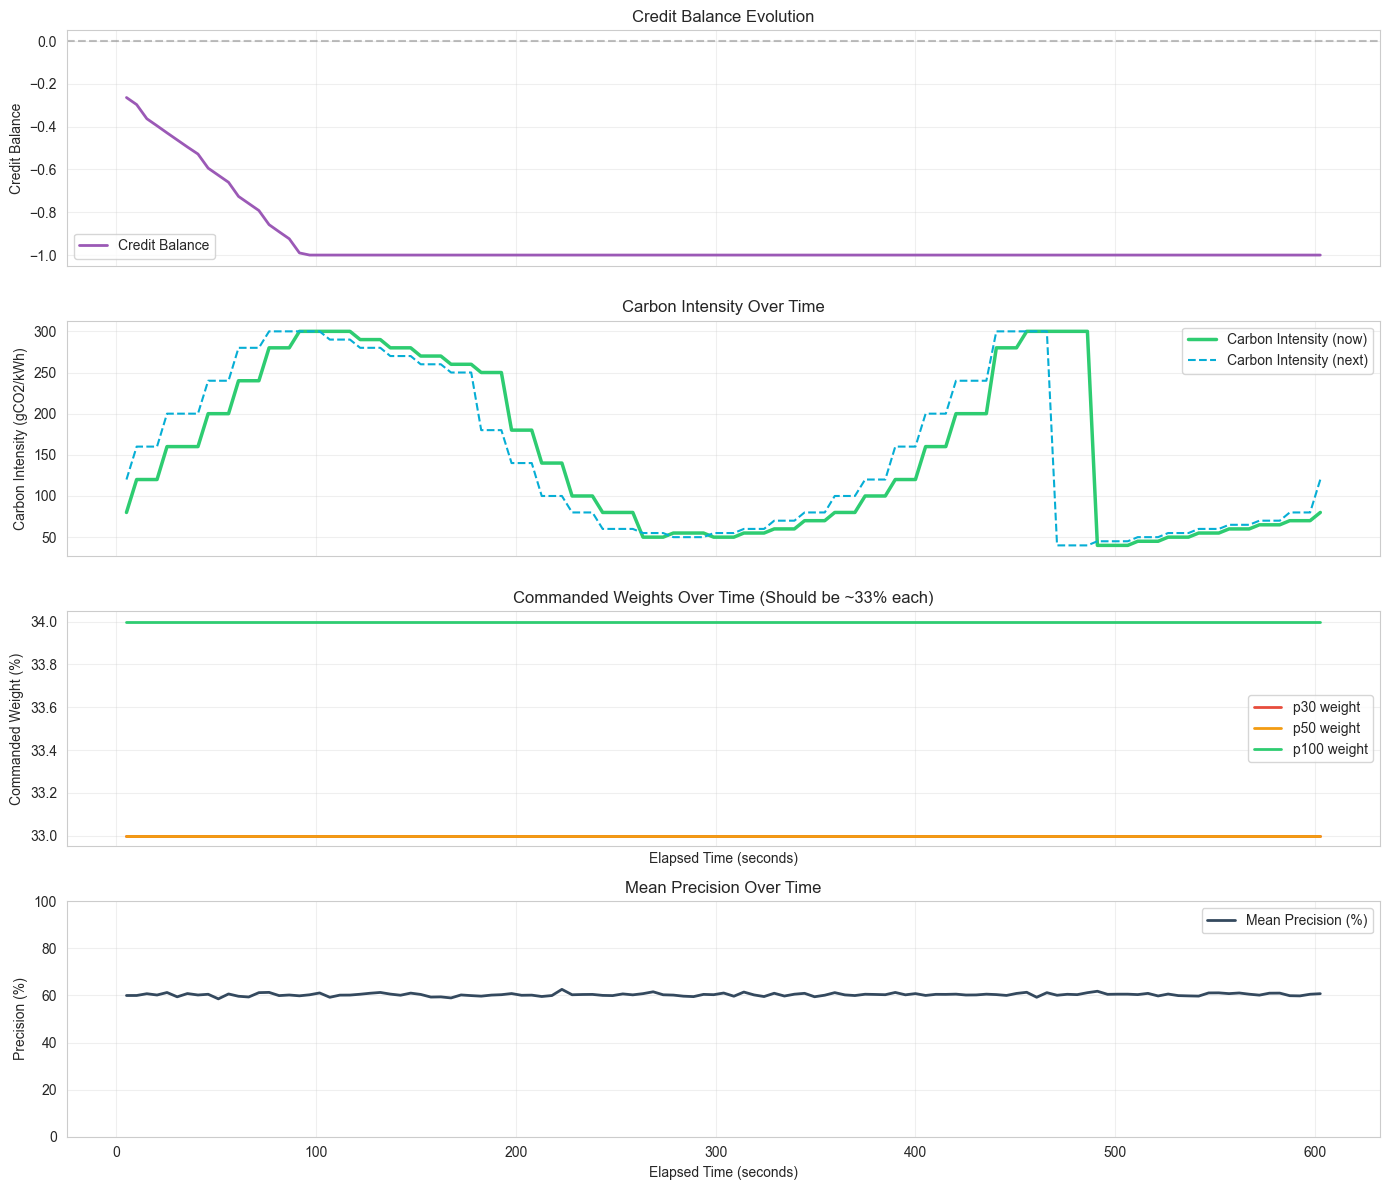

Credit balance range: -1.0000 to -0.2640
Mean credit balance: -0.9416


In [7]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1) Credit balance over time
axes[0].plot(df['elapsed_seconds'], df['credit_balance'], linewidth=2, color='#9b59b6', label='Credit Balance')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Credit Balance')
axes[0].set_title('Credit Balance Evolution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) Carbon intensity
axes[1].plot(df['elapsed_seconds'], df['carbon_now'], linewidth=2.5, color='#2ecc71', label='Carbon Intensity (now)')
if 'carbon_next' in df.columns:
    axes[1].plot(df['elapsed_seconds'], df['carbon_next'], linewidth=1.5, color='#06AED5', linestyle='--', label='Carbon Intensity (next)')
axes[1].set_ylabel('Carbon Intensity (gCO2/kWh)')
axes[1].set_title('Carbon Intensity Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3) Commanded weights over time
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_30'], linewidth=2, label='p30 weight', color='#e74c3c')
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_50'], linewidth=2, label='p50 weight', color='#f39c12')
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_100'], linewidth=2, label='p100 weight', color='#2ecc71')
axes[2].set_xlabel('Elapsed Time (seconds)')
axes[2].set_ylabel('Commanded Weight (%)')
axes[2].set_title('Commanded Weights Over Time (Should be ~33% each)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4) Mean precision over time
if 'mean_precision' in df.columns:
    actual_precision = df['mean_precision']
else:
    actual_precision = (df['requests_precision_100'].astype(float) * 1.0 +
                        df['requests_precision_50'].astype(float) * 0.5 +
                        df['requests_precision_30'].astype(float) * 0.3) / df['total_requests']

axes[3].plot(df['elapsed_seconds'], actual_precision * 100, linewidth=2, color='#34495e', label='Mean Precision (%)')

axes[3].set_xlabel('Elapsed Time (seconds)')
axes[3].set_ylabel('Precision (%)')
axes[3].set_title('Mean Precision Over Time')
axes[3].set_ylim(0, 100)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Credit balance range: {df['credit_balance'].min():.4f} to {df['credit_balance'].max():.4f}")
print(f"Mean credit balance: {df['credit_balance'].mean():.4f}")

## 6. Commanded vs Actual Traffic Distribution

Commanded Weight vs Actual Traffic Distribution:
                      p100_pct  p50_pct  p30_pct  carbon_now  samples
commanded_weight_100                                                 
34                        33.9     33.1     33.0       152.4      119



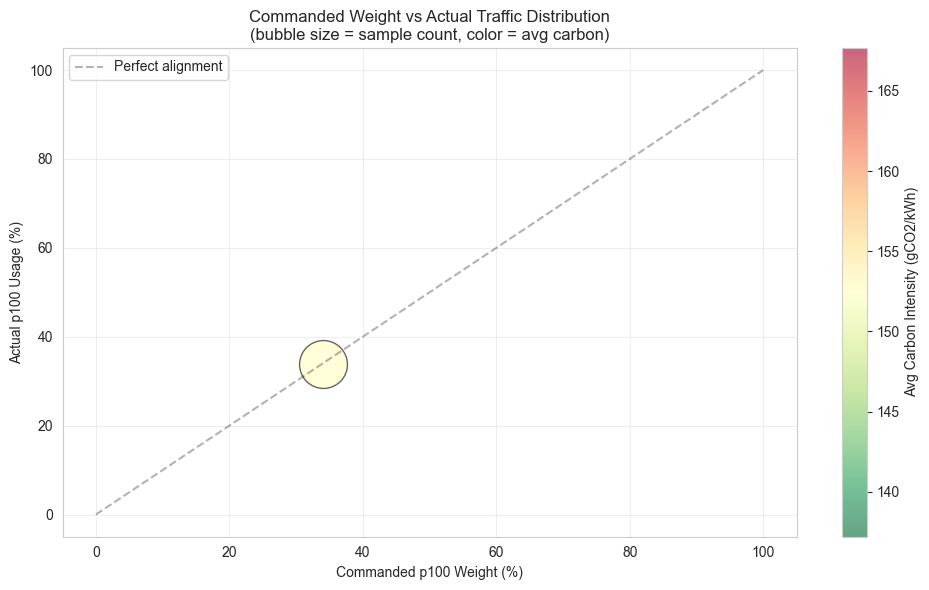

In [8]:
# Group by commanded weight to see if actual distribution matches
weight_groups = df.groupby('commanded_weight_100').agg({
    'p100_pct': 'mean',
    'p50_pct': 'mean',
    'p30_pct': 'mean',
    'carbon_now': 'mean',
    'elapsed_seconds': 'count'
}).rename(columns={'elapsed_seconds': 'samples'})

print("Commanded Weight vs Actual Traffic Distribution:")
print("=" * 80)
print(weight_groups.round(1))
print()

fig, ax = plt.subplots(figsize=(10, 6))
x = weight_groups.index
ax.scatter(x, weight_groups['p100_pct'], s=weight_groups['samples']*10, 
           c=weight_groups['carbon_now'], cmap='RdYlGn_r', alpha=0.6, edgecolors='black')
ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect alignment')
ax.set_xlabel('Commanded p100 Weight (%)')
ax.set_ylabel('Actual p100 Usage (%)')
ax.set_title('Commanded Weight vs Actual Traffic Distribution\n(bubble size = sample count, color = avg carbon)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(ax.collections[0], label='Avg Carbon Intensity (gCO2/kWh)')
plt.tight_layout()
plt.show()

## 7. Summary Statistics

In [9]:
print("=" * 80)
print("ROUND-ROBIN STRATEGY SUMMARY (BASELINE - NON-CARBON-AWARE)")
print("=" * 80)
print()
print(f"Test Duration: {df['elapsed_seconds'].max():.1f} seconds ({df['elapsed_seconds'].max()/60:.1f} minutes)")
print(f"Total Requests: {df['total_requests'].sum():.0f}")
print(f"Avg Throughput: {df['delta_requests'].mean():.1f} req/sample")
print()
print("Precision Distribution:")
print(f"  p30: {df['p30_pct'].mean():5.1f}% (range: {df['p30_pct'].min():.1f}% - {df['p30_pct'].max():.1f}%)")
print(f"  p50: {df['p50_pct'].mean():5.1f}% (range: {df['p50_pct'].min():.1f}% - {df['p50_pct'].max():.1f}%)")
print(f"  p100: {df['p100_pct'].mean():5.1f}% (range: {df['p100_pct'].min():.1f}% - {df['p100_pct'].max():.1f}%)")
print(f"  Expected: ~33.3% each")
print()
print("Carbon Intensity:")
print(f"  Range: {df['carbon_now'].min():.0f} - {df['carbon_now'].max():.0f} gCO2/kWh")
print(f"  Mean: {df['carbon_now'].mean():.1f} gCO2/kWh")
print()
print("Credit Balance:")
print(f"  Range: {df['credit_balance'].min():.4f} to {df['credit_balance'].max():.4f}")
print(f"  Mean: {df['credit_balance'].mean():.4f}")
print()
print("Baseline Behavior Verification:")
swing = abs(low['p100_pct'].mean() - high['p100_pct'].mean())
print(f"  |p100 swing| (Low - High carbon): {swing:.1f} percentage points")
if swing < 5:
    print("  ✅ Baseline working correctly: Minimal carbon sensitivity (<5 points)")
else:
    print(f"  ⚠️ Unexpected: Baseline showing carbon sensitivity ({swing:.1f} points)")

ROUND-ROBIN STRATEGY SUMMARY (BASELINE - NON-CARBON-AWARE)

Test Duration: 602.7 seconds (10.0 minutes)
Total Requests: 286231
Avg Throughput: 2405.3 req/sample

Precision Distribution:
  p30:  33.0% (range: 29.2% - 35.1%)
  p50:  33.1% (range: 30.4% - 36.3%)
  p100:  33.9% (range: 31.0% - 36.8%)
  Expected: ~33.3% each

Carbon Intensity:
  Range: 40 - 300 gCO2/kWh
  Mean: 152.4 gCO2/kWh

Credit Balance:
  Range: -1.0000 to -0.2640
  Mean: -0.9416

Baseline Behavior Verification:
  |p100 swing| (Low - High carbon): 0.2 percentage points
  ✅ Baseline working correctly: Minimal carbon sensitivity (<5 points)
